In [4]:
import torch.nn as nn
import torch.nn.functional as F

## Basic ResNet block

ResNet은 네트워크 레이어에 바로 가기 연결을 추가하고 잔여 매핑을 명시적으로 지정해 문제들을 해결한다.

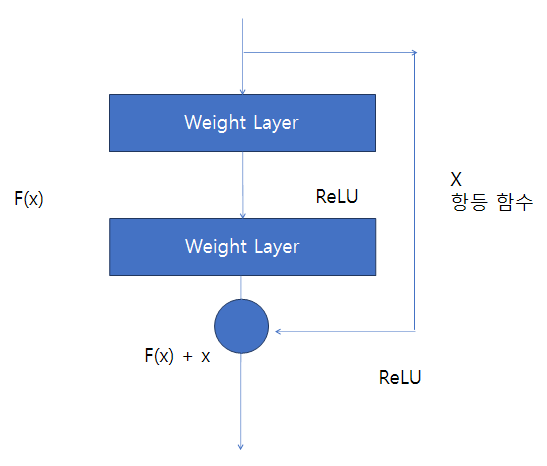

각 ResNet 블록은 일련의 레이어와 블록 입력해서 블록 출력으로 추가하는 바로 가기 연결로 구성된다. add 연산은 요소 단위로 수행되며, 입출력은 크기가 같아야 한다. 크기가 다른 경우에는 패딩을 사용할 수 있다.

In [5]:
class ResNetBasicBlock(nn.Module):
    
    def __init__(self,in_channels,out_channels,stride):
        
        super().__init__()
        # 바이어스 항이 없음
        self.conv1 = nn.Conv2d(in_channels,out_channels,kernel_size=3,stride=stride,padding=1,bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels,out_channels,kernel_size=3,stride=stride,padding=1,bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.stride = stride
        
    def forward(self,x):
        
        residual = x
        out = self.conv1(x)
        # inplace=True는 명령어를 실행한 후 메소드가 적용된 데이터 프레임을
        # 반환한다.
        # False는 기존 데이터 프렝미으로 대체하겠다는 뜻이다.
        out = F.relu(self.bn1(out),inplace=True)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual # F(x)+x
        return F.relu(out)
    
# 기존이랑 다른 점
# 입력이 반환되기 바로 전에 레이어의 출력에 다시 추가된다

torchvision에서 제공하는 모델은 다음과 같다.<br>
ResNet-18<br>
ResNet-34<br>
ResNet-50<br>
ResNet-101<br>
ResNet-152<br>

## Inception block

In [6]:
class BasicConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)


class InceptionBasicBlock(nn.Module):

    def __init__(self, in_channels, pool_features):
        super().__init__()
        self.branch1x1 = BasicConv2d(in_channels, 64, kernel_size=1)

        self.branch5x5_1 = BasicConv2d(in_channels, 48, kernel_size=1)
        self.branch5x5_2 = BasicConv2d(48, 64, kernel_size=5, padding=2)

        self.branch3x3dbl_1 = BasicConv2d(in_channels, 64, kernel_size=1)
        self.branch3x3dbl_2 = BasicConv2d(64, 96, kernel_size=3, padding=1)

        self.branch_pool = BasicConv2d(in_channels, pool_features, kernel_size=1)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch5x5 = self.branch5x5_1(x)
        branch5x5 = self.branch5x5_2(branch5x5)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch5x5, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)


